# 1. Import Dependencies and Load Data

In [2]:
#Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
#from imblearn.over_sampling import SMOTE

pd.options.display.max_columns = 200

In [3]:
#Create a path to our data
users_path = "/content/drive/MyDrive/relax_challenge/takehome_users.csv"
engagement_path = "/content/drive/MyDrive/relax_challenge/takehome_user_engagement.csv"

In [4]:
#Read in user data with proper encoding
users = pd.read_csv(users_path, encoding = "ISO-8859-1")

In [5]:
#Read in engagement data with proper encoding
engagement = pd.read_csv(engagement_path, encoding = "ISO-8859-1")

# 2. Inspect and Clean Engagement Data

In [6]:
#Grab info for engagement data frame
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
#We have no null values. Let's check out a selection of data.
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
#Let's convert time_stamp to date time
engagement['time_stamp'] = pd.to_datetime(engagement.time_stamp)

In [9]:
#We'll also set our index to the time_stamp column.
engagement = engagement.set_index('time_stamp')

In [10]:
#Let's see how many unique users we have
print(f'Unique users: {engagement.user_id.nunique()}')

Unique users: 8823


In [11]:
#We'll group by the user_id, resample into weekly, and total their visits
engagement = engagement.groupby('user_id').resample('1W').sum()
engagement

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0
...                     ...      ...
11996   2013-09-08    11996        1
11997   2013-01-20    11997        1
11998   2014-04-27    11998        1
11999   2012-06-03    11999        1
12000   2014-01-26    12000        1

[82282 rows x 2 columns]

In [12]:
#Isolate adopted users by selecting visits of 3 or more
adopted = engagement[engagement['visited'] > 2]
del adopted['user_id']
adopted

visited
user_id time_stamp         
2       2014-02-09        3
10      2013-03-03        3
        2013-04-14        3
        2013-04-28        3
        2013-05-05        4
...                     ...
11988   2014-04-06        3
        2014-05-04        4
        2014-05-18        3
        2014-05-25        5
        2014-06-01        3

[33859 rows x 1 columns]

In [13]:
#Let's calculate the unique users that have adopted the product
adopted_index = list(adopted.index)
#Create an empty list to store our unique adopted users
adopted_users =[]

for i in range(len(adopted_index)):
  adopted_users.append(adopted_index[i][0])

len(adopted_users)

33859

In [14]:
#Remove duplicates
adopted_users = set(adopted_users)

In [15]:
#Finally, lets get the number of unique users that have adopted
len(adopted_users)

1445

In [16]:
#We will add this to the users dataframe after some basic cleaning.

# 3. Inspect and Clean User Data

In [17]:
#Grab info for user dataframe
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [18]:
#Inspect the user dataframe
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [19]:
#Let's first rename columns so the dataframe is easier to understand
users = users.rename(columns = {'object_id':'user_id', 'creation_time':'account_created', 'last_session_creation_time':'last_login', 'opted_in_to_mailing_list':'marketing_emails',
                                'enabled_for_marketing_drip':'marketing_drip', 'invited_by_user_id':'invited_by'})

In [20]:
#Let's drop columns we won't need
users = users.drop(columns=['name', 'email', 'last_login'])

In [21]:
#Let's convert account_created to date time
users['account_created'] = pd.to_datetime(users.account_created)

In [22]:
#Let's also set our index to be the unique user_id
users = users.set_index('user_id')

In [23]:
#With our index set, let's mask the data frame with our adopted users list
#First, create a column for adopted and initialize it to 0, for False
users['adopted'] = 0

#Use our list of identified adopted users to mask the adopted column
for user in adopted_users:
  users.loc[user, 'adopted'] = 1

users['adopted'] = users['adopted'].astype(int)

In [24]:
#Check our changes up to this point
users.head(10)

,account_created,creation_source,marketing_emails,marketing_drip,org_id,invited_by,adopted
user_id,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1,0,11,10803.0,0
2,2013-11-15 03:45:04,ORG_INVITE,0,0,1,316.0,1
3,2013-03-19 23:14:52,ORG_INVITE,0,0,94,1525.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,0,0,1,5151.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,0,0,193,5240.0,0
6,2013-12-17 03:37:06,GUEST_INVITE,0,0,197,11241.0,0
7,2012-12-16 13:24:32,SIGNUP,0,1,37,NaN,0
8,2013-07-31 05:34:02,PERSONAL_PROJECTS,1,1,74,NaN,0
9,2013-11-05 04:04:24,PERSONAL_PROJECTS,0,0,302,NaN,0


In [25]:
#Let's begin to address our missing values.
users.isnull().sum()

account_created        0
creation_source        0
marketing_emails       0
marketing_drip         0
org_id                 0
invited_by          5583
adopted                0
dtype: int64

In [26]:
#We will replace the NaN values in "invited_by" that represent uses which were not invited with an id of "0"
users['invited_by'].fillna(0, inplace=True)

#While we're at it, let's cast the invited_by ids to an integer
users['invited_by'] = users['invited_by'].astype(int)

In [27]:
users.head(10)

,account_created,creation_source,marketing_emails,marketing_drip,org_id,invited_by,adopted
user_id,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1,0,11,10803,0
2,2013-11-15 03:45:04,ORG_INVITE,0,0,1,316,1
3,2013-03-19 23:14:52,ORG_INVITE,0,0,94,1525,0
4,2013-05-21 08:09:28,GUEST_INVITE,0,0,1,5151,0
5,2013-01-17 10:14:20,GUEST_INVITE,0,0,193,5240,0
6,2013-12-17 03:37:06,GUEST_INVITE,0,0,197,11241,0
7,2012-12-16 13:24:32,SIGNUP,0,1,37,0,0
8,2013-07-31 05:34:02,PERSONAL_PROJECTS,1,1,74,0,0
9,2013-11-05 04:04:24,PERSONAL_PROJECTS,0,0,302,0,0


In [28]:
#We can now create our dummy variables. For readability, we will cast the org_id and invited_by columns as objects.
users = users.astype({'org_id': str, 'invited_by': str})

In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   account_created   12000 non-null  datetime64[ns]
 1   creation_source   12000 non-null  object        
 2   marketing_emails  12000 non-null  int64         
 3   marketing_drip    12000 non-null  int64         
 4   org_id            12000 non-null  object        
 5   invited_by        12000 non-null  object        
 6   adopted           12000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1008.0+ KB


In [30]:
#We'll create dummies for categorical variables creation_source, org_id, and invited_by in one shot.
dummies = pd.get_dummies(users[['creation_source', 'org_id', 'invited_by']])
df = pd.concat([users, dummies], axis = 1)

#Let's drop some unneeded columns and finalize our dataframe
df.drop(['account_created', 'creation_source', 'org_id', 'invited_by'], axis=1, inplace=True)

In [31]:
df.head()

,marketing_emails,marketing_drip,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,org_id_1,org_id_10,org_id_100,org_id_101,org_id_102,org_id_103,org_id_104,org_id_105,org_id_106,org_id_107,org_id_108,org_id_109,org_id_11,org_id_110,org_id_111,org_id_112,org_id_113,org_id_114,org_id_115,org_id_116,org_id_117,org_id_118,org_id_119,org_id_12,org_id_120,org_id_121,org_id_122,org_id_123,org_id_124,org_id_125,org_id_126,org_id_127,org_id_128,org_id_129,org_id_13,org_id_130,org_id_131,org_id_132,org_id_133,org_id_134,org_id_135,org_id_136,org_id_137,org_id_138,org_id_139,org_id_14,org_id_140,org_id_141,org_id_142,org_id_143,org_id_144,org_id_145,org_id_146,org_id_147,org_id_148,org_id_149,org_id_15,org_id_150,org_id_151,org_id_152,org_id_153,org_id_154,org_id_155,org_id_156,org_id_157,org_id_158,org_id_159,org_id_16,org_id_160,org_id_161,org_id_162,org_id_163,org_id_164,org_id_165,org_id_166,org_id_167,org_id_168,org_id_169,org_id_17,org_id_170,org_id_171,org_id_172,org_id_173,org_id_174,org_id_175,org_id_176,org_id_177,org_id_178,org_id_179,org_id_18,org_id_180,...,invited_by_9572,invited_by_9577,invited_by_9579,invited_by_9582,invited_by_9584,invited_by_9587,invited_by_9589,invited_by_959,invited_by_9590,invited_by_9593,invited_by_9596,invited_by_960,invited_by_9601,invited_by_9602,invited_by_9604,invited_by_9606,invited_by_9607,invited_by_9608,invited_by_9621,invited_by_9625,invited_by_9628,invited_by_9631,invited_by_9648,invited_by_9650,invited_by_9653,invited_by_9657,invited_by_966,invited_by_9661,invited_by_9676,invited_by_9685,invited_by_969,invited_by_9691,invited_by_9692,invited_by_9694,invited_by_9700,invited_by_9702,invited_by_9703,invited_by_9709,invited_by_9713,invited_by_9720,invited_by_9724,invited_by_9726,invited_by_9728,invited_by_9732,invited_by_9736,invited_by_9738,invited_by_9744,invited_by_9745,invited_by_975,invited_by_9751,invited_by_9757,invited_by_9760,invited_by_9763,invited_by_9764,invited_by_9769,invited_by_9770,invited_by_9774,invited_by_9777,invited_by_9781,invited_by_9785,invited_by_979,invited_by_9790,invited_by_9793,invited_by_9795,invited_by_9797,invited_by_9799,invited_by_980,invited_by_9802,invited_by_9804,invited_by_9805,invited_by_9810,invited_by_9819,invited_by_9822,invited_by_9838,invited_by_9841,invited_by_985,invited_by_9855,invited_by_9858,invited_by_9862,invited_by_9872,invited_by_9895,invited_by_9899,invited_by_9901,invited_by_9912,invited_by_9916,invited_by_9919,invited_by_9922,invited_by_9923,invited_by_9925,invited_by_9934,invited_by_9935,invited_by_9953,invited_by_9958,invited_by_9959,invited_by_9964,invited_by_9968,invited_by_9985,invited_by_9986,invited_by_9995,invited_by_9997
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# 4. Model

In [32]:
#First, we split we'll split off our target.
X = df.drop(['adopted'], axis=1)
y = df['adopted']

In [33]:
#Now, we'll split the data into training and test sets. We stratify because our dataset is imbalanced.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [34]:
#We'll go with a reliable ensemble model for this problem - Random Forest
rf = RandomForestClassifier(random_state=42)

#Train the model
rf.fit(X_train, y_train)

#Predict on test data
y_pred = rf.predict(X_test)

# 5. Evaluate

In [35]:
#Let's see how our model did.
print(f'Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Testing Accuracy: {rf.score(X_test, y_test)}')

Training Accuracy: 0.9398958333333334
Testing Accuracy: 0.8520833333333333


In [36]:
print("Classification Report")
print(classification_report(y_test, y_pred))


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2111
           1       0.19      0.07      0.10       289

    accuracy                           0.85      2400
   macro avg       0.54      0.51      0.51      2400
weighted avg       0.80      0.85      0.82      2400



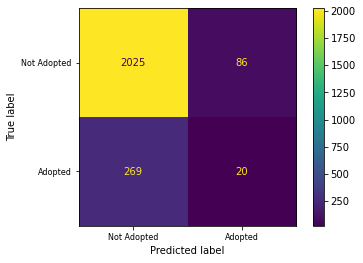

In [37]:
#Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = rf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Not Adopted', 'Adopted'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Not Adopted', 'Adopted'], fontsize = 8)
ax.set_yticklabels(labels = ['Not aAdopated', 'Adopted'], fontsize = 8)
display_cm.plot(ax = ax)

30


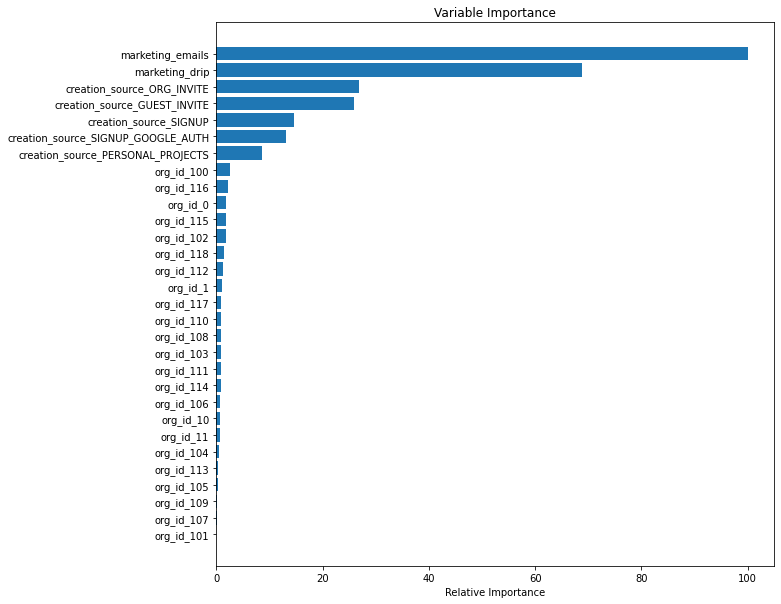

In [38]:
#Let's plot feature importance
feature_importance = rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 6. Conclusions
Based on our analysis, we can identify key factors the predict user adoption

### Key Predictors
*   Users that opt into marketing emails are far more likely to become adopted users. This is our strongest predictor.
*   Users on the regular marketing email drip are also far more likely to become adopted users. Taken with our first point, it's looking like marketing plays a strong role in determining user adoption.
*   The next most likely predictor is whether or not a user was invited to an organization, whether it be as a guest or full member.
*   Our final notable predictor is whether the user was invited by another user.

### Recommendations 
Based on the above, I would recommend the following:

*   Invest more heavily in getting users on the marketing email list. It would seem some combination of marketing/promotions keep users invested in the platform for longer.
*   Ensure users are on the marketing drip, and ensure that drip is optimized
*   Finally, ensure the company is working with organizations and individual users to encourage invites, potentially by offering some sort of incentive for them to do so.

### Model Adjustments
Based on our feature importances, I would tweak our model to reflect a few things.
*   It does not appear to be too important which particular organization invited a user. Rather, whether an organization invited a user or not. We could perform dimensionality reduction and improve our model by creating a feature that identifies whether the user was invited by an organization or not.
*   Similarly, we could do the same for user invites.
*   Currently, adopted users are defined in static weekly windows. We may be better served to use a form of rolling 7 day window to more accurately capture user activity. 














